In [1]:
import numpy as np
import matplotlib.pyplot as plt

import stan_utils as stan
from mpl_utils import (mpl_style, common_limits)

plt.style.use(mpl_style)

np.random.seed(42)

%matplotlib inline

In [2]:
def generate_data(N, M, D, overlap_fraction=None, scales=None,
                  phi_scale=1, seed=None):
    """
    Generate some toy data to play with. 
    
    :param N:
        The number of stars observed.

    :param M:
        The number of surveys.

    :param D:
        The dimensionality of the label space.

    :param overlap_fraction: [optional]
        The approximate fraction of stars observed by each survey. If `None` is
        provided then some random ~50% of stars will be observed by each survey.
        If provided, this should be a list of length `M` with values between 0
        (no overlap) and 1 (complete overlap).

    :param scales: [optional]
        Optional values to provide for the relative scales on the latent factors.

    :param seed: [optional]
        An optional seed to provide to the random number generator.
        
    :param phi_scale: [optional]
        An optional scale value for the uncertainties.

    :returns:
        A two-length tuple containing the data :math:`y` and a dictionary with
        the true values.
    """

    if seed is not None:
        np.random.seed(seed)

    if scales is None:
        scales = np.abs(np.random.normal(0, 1, size=D))

    else:
        scales = np.array(scales)
        
    if overlap_fraction is None:
        overlap_fraction = np.random.normal(0.5, 0.05, size=M)
    else:
        overlap_fraction = np.array(overlap_fraction)
        assert  overlap_fraction.size == M
        

    assert len(scales) == D

    X = np.random.normal(
        np.zeros(D),
        scales,
        size=(N, D))

    # TODO: Think up better way to randomly generate positive definite covariance
    #       matrices that are *very* close to an identity matrix.

    # Use Cholesky decomposition to ensure the resulting covariance matrix is 
    # positive definite.
    L = np.random.randn(M, D, D)
    L[:, np.arange(D), np.arange(D)] = np.exp(L[:, np.arange(D), np.arange(D)])
    i, j = np.triu_indices_from(L[0], 1)
    L[:, i, j] = 0.0

    theta = np.array([np.dot(L[i], L[i].T) for i in range(M)])

    y = np.dot(X, theta)
    for m, of in enumerate(overlap_fraction):
        indices = np.where(np.random.uniform(0, 1, size=N) <= of)[0]
        y[indices, m, :] = np.nan
        
    # add noise.
    phi = np.abs(np.random.normal(0, phi_scale, size=(M, D)))
    rank = np.random.normal(0, 1, size=y.shape)

    noise = scales * rank * phi 

    y += noise
    
    
    truths = dict(X=X, theta=theta, phi=phi, scales=scales, L=L, noise=noise)

    return (y, truths)

In [3]:
N, M, D = (250, 10, 5)
scales = np.ones(D)
phi_scale = 1

y, truths = generate_data(N=N, M=M, D=D, 
                          scales=scales, 
                          phi_scale=phi_scale)

In [41]:
# Create an additive variance array to account for missing data.
def de_gapify_data(y, additional_variance=1e8):
    """
    Fill NaNs in the label vectors with the mean values of other
    labels. No structure is assumed for the missing labels (e.g.,
    some labels could be missing from some surveys, but not all).
    
    :param y:
        The label vector, where NaNs represent missing data.
    
    :param additional_variance: [optional]
        The variance to add for missing data.
    """
    
    N, M, D = y.shape
    missing = ~np.isfinite(y)
    mean_labels = np.nanmean(y, axis=1)
    
    y_full_rank = np.copy(y)
    variance = np.zeros_like(y)
    for m in range(M):
        y_full_rank[:, m, :][missing[:, m, :]] = mean_labels[missing[:, m, :]]
        variance[:, m, :][missing[:, m, :]] = 1.0
    
    variance *= additional_variance
    
    return (y_full_rank, variance)

y_full_rank, extra_variance = de_gapify_data(y)

In [44]:
model = stan.read_model("model-missing-data.stan")
print(model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ca6366cf3cdb64f5dbb7e41b4cb69f3a NOW.



/*
  Latent factor model for chemical abundances from multiple studies, allowing
  for missing data.
*/

data {
  int<lower=1> N; // number of stars
  int<lower=1> D; // dimensionality of the data (number of labels)
  int<lower=1> M; // number of surveys (or studies)
  vector[D] y[N, M]; // the labels as reported by various surveys.
  vector<lower=0>[D] scales; // fixed relative scales for latent factors
  vector[D] y_additive_variance[N, M]; // variance to add for missing data.
}

transformed data {
  vector[D] mu; // the mean of the data in each dimension
  int<lower=1> Q; // the number of non-zero lower-triangular entries that we
                  // need for the decomposoition of our theta matrix
  Q = M * choose(D, 2);

  // TODO: Stop assuming that the user is not an idiot
  mu = rep_vector(0.0, D);
}

parameters {
  vector[D] X[N]; // latent factors for each star
  vector<lower=0>[M] phi[D]; // variance on survey labels

  vector[Q] L_lower_triangular; // lower triangular entri

In [45]:
# Optimize the model
data = dict(N=N, M=M, D=D, scales=scales, 
            y=y_full_rank, y_additive_variance=extra_variance)

op_kwds = dict(
    data=data, 
    iter=100000, 
    tol_obj=7./3 - 4./3 - 1, # machine precision
    tol_grad=7./3 - 4./3 - 1, # machine precision
    tol_rel_grad=1e3,
    tol_rel_obj=1e4
)

p_opt = model.optimizing(**op_kwds)

/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:362: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(np.asarray(v).dtype, int):
/Users/arc/anaconda2/envs/py3/lib/python3.6/site-packages/pystan/misc.py:364: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


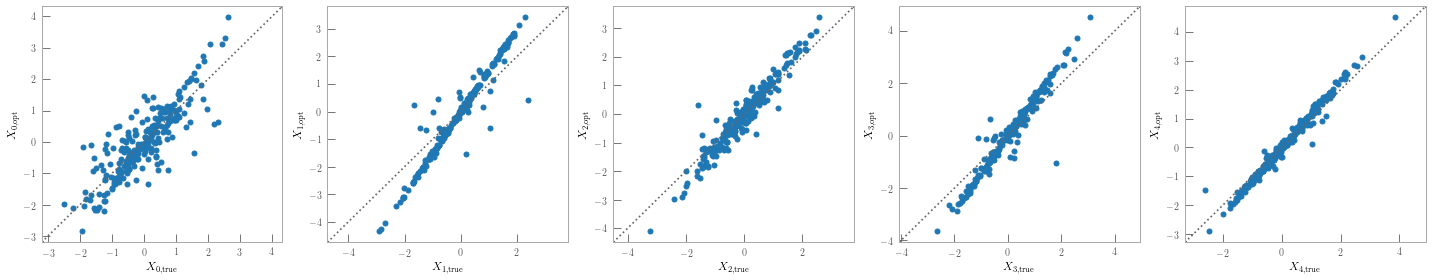

In [46]:
fig, axes = plt.subplots(1, D, figsize=(4 * D, 4))
for d, ax in enumerate(axes):

    x = truths["X"].T[d]
    y = p_opt["X"].T[d]

    ax.scatter(x, y)

    ax.set_xlabel(r"$X_{{{0},\textrm{{true}}}}$".format(d))
    ax.set_ylabel(r"$X_{{{0},\textrm{{opt}}}}$".format(d))

    common_limits(ax, plot_one_to_one=True)

fig.tight_layout()

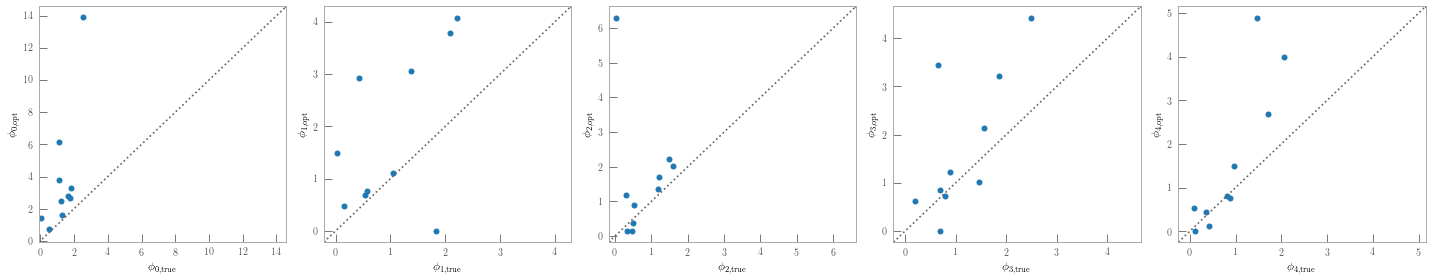

In [47]:
fig, axes = plt.subplots(1, D, figsize=(4 * D, 4))
for d, ax in enumerate(axes):

    x = truths["phi"].T[d]
    y = p_opt["phi"][d]

    ax.scatter(x, y)

    ax.set_xlabel(r"$\phi_{{{0},\textrm{{true}}}}$".format(d))
    ax.set_ylabel(r"$\phi_{{{0},\textrm{{opt}}}}$".format(d))

    common_limits(ax, plot_one_to_one=True)

fig.tight_layout()

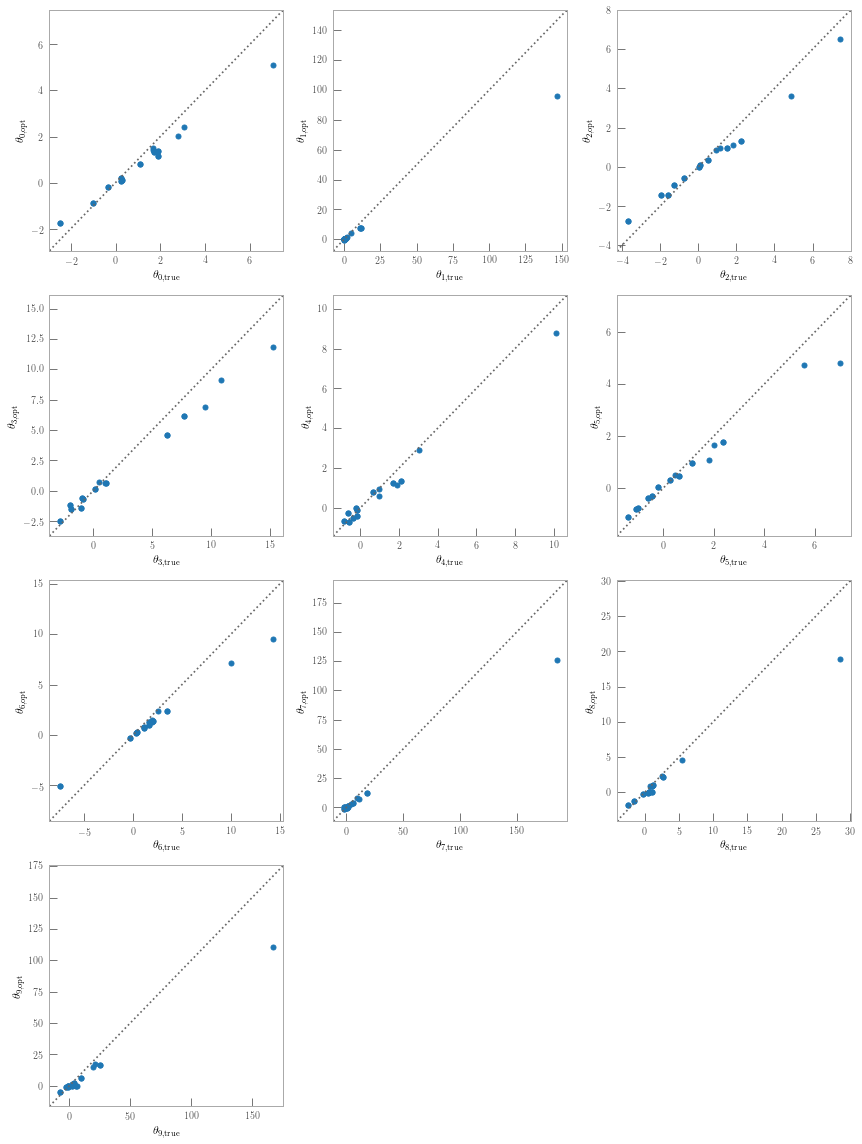

In [48]:
K = int(np.ceil(M**0.5))
L = int(np.ceil(M / K))

fig, axes = plt.subplots(K, L, figsize=(4 * L, 4 * K))
axes = np.array(axes).flatten()

for m, ax in enumerate(axes[:M]):

    x = truths["theta"][m].flatten()
    y = p_opt["theta"][m].flatten()

    ax.scatter(x, y)

    ax.set_xlabel(r"$\theta_{{{0},\textrm{{true}}}}$".format(m))
    ax.set_ylabel(r"$\theta_{{{0},\textrm{{opt}}}}$".format(m))
    
    common_limits(ax, plot_one_to_one=True)

for ax in axes[M:]:
    ax.set_visible(False)

fig.tight_layout()